In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os

import tensorflow as tf 
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import numpy as np
from pathlib import Path
import cv2

# Display F. Chollet example
import matplotlib
from skimage.transform import resize

from cgmml.common.evaluation.eval_utils import tf_load_pickle
from run_gradcam import show_depthmaps, overlay_depthmap_gradcam, extract_last_conv_layer_name

REPO_DIR = Path(os.getcwd()).parents[2].absolute()


In [5]:
print(matplotlib.get_backend())

module://matplotlib_inline.backend_inline


In [6]:
output_location = (REPO_DIR / 'data' / 'q3-depthmap-plaincnn-height-95k')
model_file_path = (output_location / 'outputs' / 'best_model.ckpt')


In [7]:
height_model = tf.keras.models.load_model(model_file_path, compile=False)

2021-10-12 12:35:37.400554: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-12 12:35:37.401657: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.01)
# Compile the model.
height_model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy"]
            )

In [ ]:
#height_model.summary() 
#check the run in cgm-rg

### Download dataset and find some examples

In [ ]:
# ALREADY DOWNLOADED
#dataset = Dataset.get_by_name(workspace, name='anon-depthmap-mini')
#dataset.download(target_path='./dataset', overwrite=False)

In [9]:
scan_paths = ["./dataset/scans/1585273581-kkzed7slcb/101/pc_1585273581-kkzed7slcb_1592533609843_101_011.p",
              "./dataset/scans/1585273961-7dw2qedbor/100/pc_1585273961-7dw2qedbor_1592533886956_100_000.p", 
              "./dataset/scans/1585273961-7dw2qedbor/100/pc_1585273961-7dw2qedbor_1592533886956_100_014.p",
              "./dataset/scans/1585356905-3hddkdz687/100/pc_1585356905-3hddkdz687_1592798873065_100_000.p",
              "./dataset/scans/1585356905-3hddkdz687/100/pc_1585356905-3hddkdz687_1592798873065_100_006.p"]

In [10]:
depthmaps = []

for path in scan_paths:
    normalization_value = 7.5
    depthmap, target = tf_load_pickle(path, normalization_value)
    depthmap_np = np.array(depthmap)
    depthmaps.append(depthmap_np)

print(type(depthmaps[0]))
print(depthmaps[0].shape)


<class 'numpy.ndarray'>
(240, 180, 1)


In [ ]:
show_depthmaps(depthmaps)

### Prepare depthmap

In [11]:
#FROM CGM-RG

IMAGE_TARGET_HEIGHT = 240
IMAGE_TARGET_WIDTH = 180
NORMALIZATION_VALUE = 7.5

def preprocess_depthmap(depthmap):
    return depthmap.astype("float32")

def preprocess(depthmap):
    depthmap = preprocess_depthmap(depthmap)
    depthmap = depthmap / NORMALIZATION_VALUE
    depthmap = resize(depthmap, (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH))
    depthmap = depthmap.reshape((depthmap.shape[0], depthmap.shape[1], 1))
    return depthmap

In [20]:
preprocessed_depthmaps = []

for depthmap in depthmaps:
    preprocessed_depthmap = preprocess(depthmap)
    ##### NEITHER NEW CODE NOR height_model.predict WORKS WITHOUT batch dim - must be in cgm-rg somewhere
    preprocessed_depthmap = np.expand_dims(preprocessed_depthmap, axis=0)
    preprocessed_depthmaps.append(preprocessed_depthmap)

print(type(preprocessed_depthmaps))
print(type(preprocessed_depthmaps[0].shape))
print(len(preprocessed_depthmaps))
#print(preprocessed_depthmaps[0])

<class 'list'>
<class 'tuple'>
5


# Create heatmap

In [45]:
last_conv_layer_name = extract_last_conv_layer_name(height_model)
print(last_conv_layer_name)

conv2d_11


## 2nd Gradcam Implementation - with subgraph creation + two simultaneous ouputs

In [21]:
# from https://gist.github.com/RaphaelMeudec/e9a805fa82880876f8d89766f0690b54
# understand this implementation better: https://www.sicara.ai/blog/2019-08-28-interpretability-deep-learning-tensorflow

## this is how the function should look like
#def get_height_prediction_and_heatmap_local(numpy_array): 
#return height, heatmap
    #re-write below function to only take numpy_array, not height_model 
        # height_model is global in cgm-rg, make grad_model also global in cgm-rg

# THIS creates a connection between the inputs and our target outputs which is output of last conv layer and height pred output = SUBGRAPH CREATION
# SUBGRAPH CREATION = obtain output from a specific layer
grad_model = Model(inputs=[height_model.inputs], 
                        outputs=[height_model.get_layer(last_conv_layer_name).output, height_model.output])


# GRADCAM checks the importance of output filters (here: last conv layer) towards the final decision
def compute_pred_and_heatmap(numpy_array):
    
    # GET the score for target prediction
    with tf.GradientTape() as tape:
        numpy_array = tf.cast(numpy_array, tf.float32)
        (conv_outputs, height_prediction) = grad_model(np.array(numpy_array))
        print("pred.shape = ", height_prediction.shape)
        print("predictions", height_prediction)
        print("predictions[0]", height_prediction[0])
        # THIS is the difference between CLASS activation and regression: in class activation, we input the specific class index here, 
        # e.g. 2= cat. then, we read out the probability for cat in the flattened predictions at index "cat" and use this to get the activation from gradients
        # IN OUR CASE: we do not have classes, we do regression. So: we have one height value in the zeroth index of our predictions tensor. And we want to see where the 
        # activation was in the last conv layer for this prediction

        # IMPORTANT: Since we always will only have one prediction (1 depthmap is processed at a time, in regression we do not have multiple class predictions but only one scalar), 
        # we can leave the next block out
        #classIdx = np.argmax(height_predictions[0]) # returns index of prediction
        #loss = height_predictions[:, classIdx] 
    
    # EXTRACT filters and gradients
    output = conv_outputs[0]
    grads = tape.gradient(height_prediction, conv_outputs)[0]

    # GUIDED backpropagation - eliminating elements that act negatively towards the decision - zeroing-out negative gradients
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads
    
    # AVERAGE gradients spatially
    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    # BUILD a weighted map of filters according to gradients importance
    cam = np.ones(output.shape[0: 2], dtype = np.float32)
    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    # HEATMAP visualization
    cam = cv2.resize(cam.numpy(), (IMAGE_TARGET_HEIGHT, IMAGE_TARGET_WIDTH))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    return heatmap, height_prediction

In [22]:
depthmap_test = preprocessed_depthmaps[1]

In [23]:
heatmap_res, heightpred_res = compute_pred_and_heatmap(height_model, depthmap_test)

pred.shape =  (1, 1)
predictions tf.Tensor([[90.03042]], shape=(1, 1), dtype=float32)
predictions[0] tf.Tensor([90.03042], shape=(1,), dtype=float32)
prediction =  tf.Tensor([90.03042], shape=(1,), dtype=float32)


In [24]:
print(heightpred_res)

tf.Tensor([90.03042], shape=(1,), dtype=float32)


In [25]:
height_model.predict(depthmap_test)

array([[90.03042]], dtype=float32)

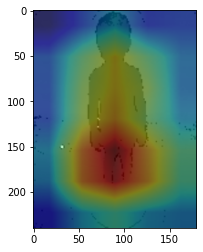

array([[[  0,   0,  51],
        [ 28,  28,  78],
        [ 44,  44,  95],
        ...,
        [ 44,  67, 146],
        [ 44,  67, 146],
        [ 44,  67, 146]],

       [[ 28,  28,  78],
        [ 38,  38,  89],
        [ 44,  44,  95],
        ...,
        [ 44,  67, 146],
        [ 44,  67, 146],
        [ 44,  67, 146]],

       [[ 44,  44,  95],
        [ 44,  44,  95],
        [ 44,  44,  95],
        ...,
        [ 34,  56, 136],
        [ 34,  57, 136],
        [ 44,  67, 146]],

       ...,

       [[  8,   8, 110],
        [ 17,  17, 118],
        [ 22,  22, 124],
        ...,
        [ 22,  83, 124],
        [ 22,  83, 124],
        [ 22,  83, 124]],

       [[  0,   0, 102],
        [  8,   8, 110],
        [ 17,  17, 118],
        ...,
        [ 22,  83, 124],
        [ 22,  83, 124],
        [ 22,  83, 124]],

       [[  0,   0, 102],
        [  0,   0, 102],
        [  8,   8, 110],
        ...,
        [ 22,  83, 124],
        [ 22,  83, 124],
        [ 22,  83, 124]]

In [26]:
overlay_depthmap_gradcam(depthmap_test, heatmap_res)

___________________________________________________________________

In [ ]:
""" def compute_pred_and_heatmap(height_model, image): - version P + online mixed

    grad_model = Model(inputs=[height_model.inputs], 
                            outputs=[height_model.get_layer(last_conv_layer_name).output, height_model.output])

    with tf.GradientTape() as tape:
        #tape.watch(grad_model.get_layer(last_conv_layer_name).output)
        inputs = tf.cast(image, tf.float32)
        (conv_outputs, predictions) = grad_model(inputs)
        print("pred.shape = ", predictions.shape)
        print(predictions)
        classIdx = np.argmax(predictions[0])

        if len(predictions)==1:
            loss = predictions[0]
        else:
            loss = predictions[:, classIdx] 
    
    grads = tape.gradient(loss, conv_outputs)
    
    return_pred = loss  # this name from exmpl is confusing - is this right?

    cast_conv_outputs = tf.cast(conv_outputs > 0, "float32")
    cast_grads = tf.cast(grads > 0, "float32")
    guided_grads = cast_conv_outputs * cast_grads * grads 

    conv_outputs = conv_outputs[0]
    guided_grads = guided_grads[0]

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())
    heatmap = (heatmap * 255).astype("float32")
    return heatmap, return_pred """